# Homework 1

## Imitation learning & DAgger

### Warmup

The starter code provides an expert policy for each of the MuJoCo tasks in OpenAI gym (See `run_expert.py`). Generate roll-outs from the provided policies, and implement behavioral cloning. Run behavioral cloning (BC) on the Hopper-v1 environment, and report a learning curve plotting the loss function for the behavior cloning objective versus number of learning iterations. Your plot should show the (training) loss as a function of the number of gradient steps, and the loss should be improving over time. However, there is no other requirement for the warmup – you do not have to report any measure of final performance, just demonstrate that the network is training and the loss is improving

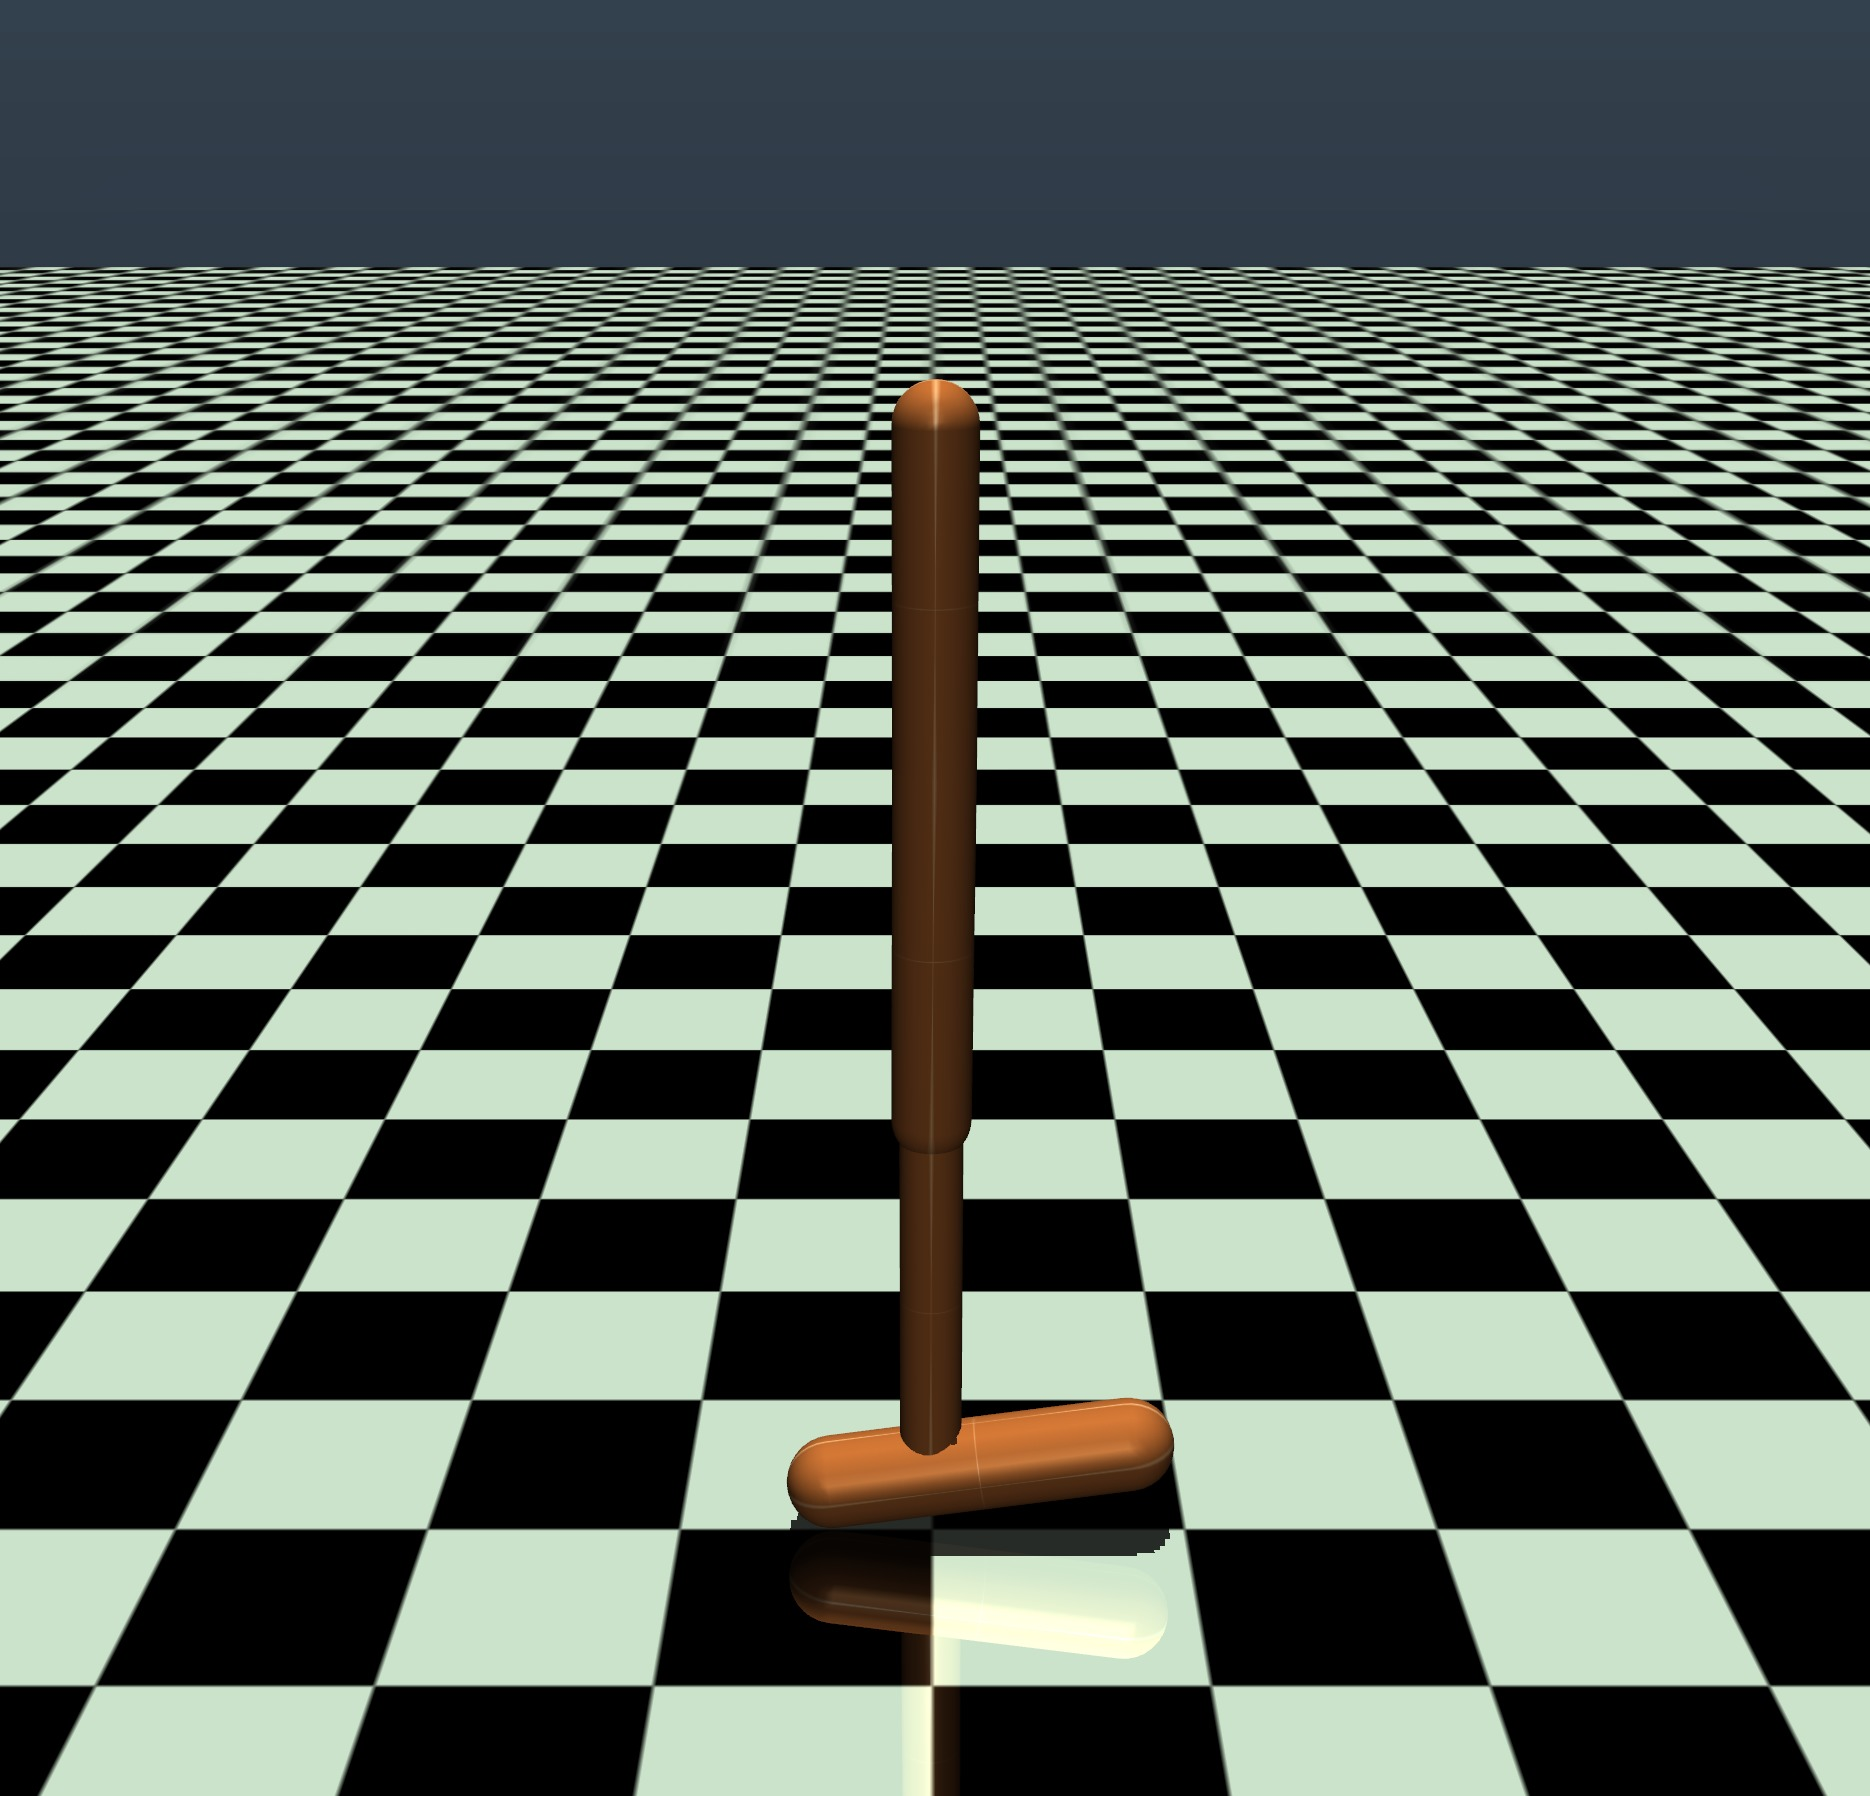


In [1]:
"""
I generate the training database using the code from `run_expert.py`
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy

def GenerateWarmupData(num_rollouts):
    """
    Generates a database of expert observation-action pair of size `num_rollouts` 
    """

    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/Hopper-v1.pkl')
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        # it is cool thing to note that not every library is imported at the beginning
        # Especially useful when loading multiple large libraries
        import gym
        env = gym.make('Hopper-v1')
        max_steps = env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)
        
        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions).squeeze()}
    return expert_data

/home/botoscs/.virtualenvs/all/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
expert_data = GenerateWarmupData(20)

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2018-04-08 20:16:08,240] From /home/botoscs/brdl-homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2018-04-08 20:16:08,251] From /home/botoscs/.virtualenvs/all/lib/python3.5/site-packages/tensorflow/python/util/tf_should_use.py:118: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2018-04-08 20:16:08,261] Making new env: Hopper-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
returns [3774.9592467429175, 3774.403442069187, 3773.1737005420205, 3774.525212719326, 3777.030596933036, 3777.7980935355886, 3776.017687595559, 3777.5729845532032, 3777.321982736748, 3778.425552301009, 3777.2645670835254, 3782.3512880324147, 3779.095879693781, 3791.320222371548, 3775.6173334507744, 3780.1377078163982, 3779.522614479995, 3782.4608229978885, 3774.672826316517, 3779.507495624121]
mean return 3778.1589628797774
std of return 3.9159112498120017


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 10

(20000, 11)


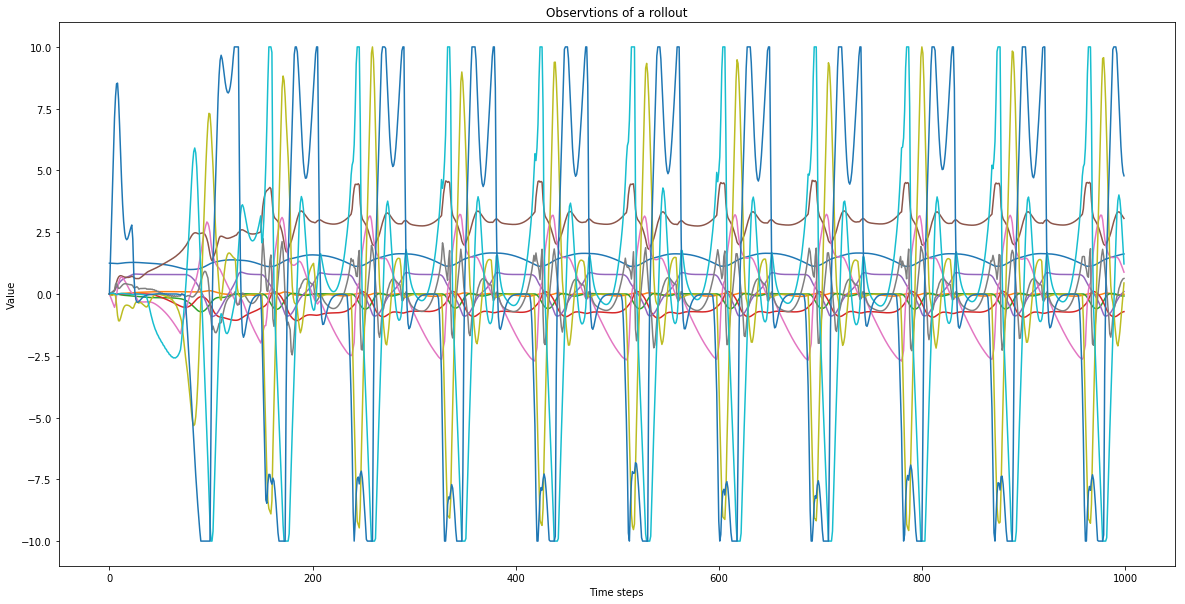

(20000, 3)


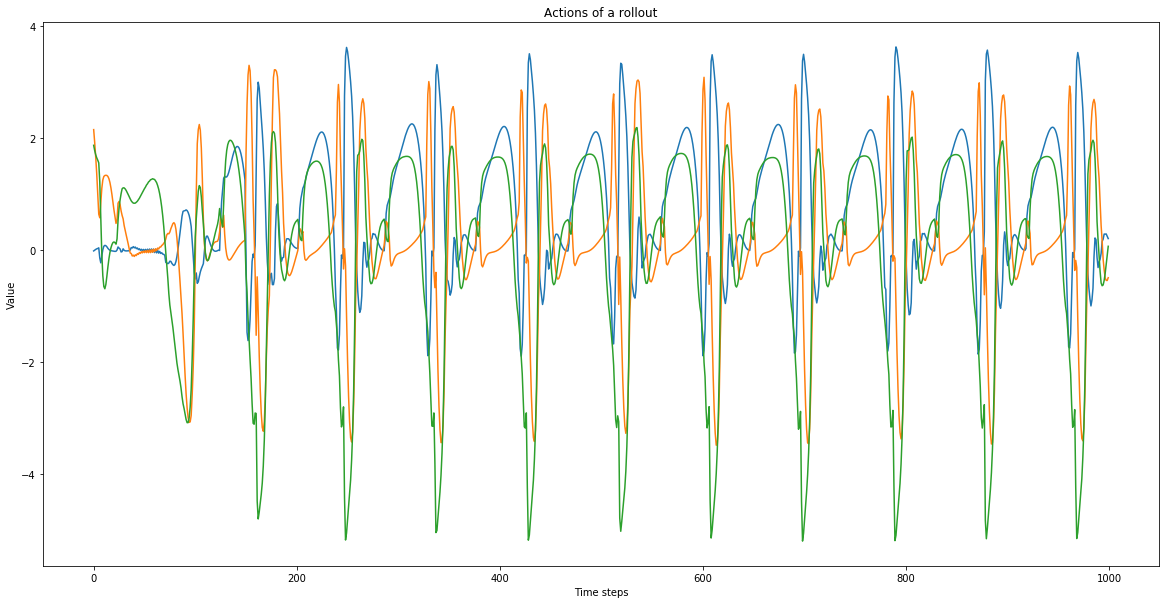

In [5]:
print(expert_data['observations'].shape)
plt.plot(expert_data['observations'][:1000])
plt.title('Observtions of a rollout')
plt.ylabel('Value')
plt.xlabel('Time steps')
plt.show()


print(expert_data['actions'].shape)
plt.plot(expert_data['actions'][:1000])
plt.title('Actions of a rollout')
plt.ylabel('Value')
plt.xlabel('Time steps')
plt.show()

In [6]:
"""
Now I just do the good-ol supervised learning
"""
import torch
from torch.nn import Linear, ReLU

def getMLP(input_dim, output_dim, hidden_dims):    
    """
    A vanilla MLP generator, with ReLU hidden, and Linear output layer
    """
    # Initial layers
    layers = [
        Linear(input_dim, hidden_dims[0]),
        ReLU()
    ]
    
    # Hidden layers
    prev_dim = hidden_dims[0]
    for h_dim in hidden_dims[1:]:
        layers.append(Linear(prev_dim, h_dim))
        layers.append(ReLU())
        prev_dim = h_dim
                   
    # Output layer
    layers.append(Linear(hidden_dims[-1], output_dim, bias=False))
    
    MLP = torch.nn.Sequential(*layers)
    return MLP

In [7]:
"""
Defining the policy network
"""
input_dim = expert_data['observations'].shape[-1]
output_dim = expert_data['actions'].shape[-1]
hidden_dims = [64]

policy_net = getMLP(input_dim, output_dim, hidden_dims)
print(policy_net)

Sequential(
  (0): Linear(in_features=11, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=3)
)


In [8]:
"""
Training the policy network
"""
from torch.autograd import Variable
from torch import FloatTensor

X = Variable(FloatTensor(expert_data['observations']))
Y = Variable(FloatTensor(expert_data['actions']))
if torch.cuda.is_available():
    X = X.cuda()
    Y = Y.cuda()
    policy_net.cuda()
    
loss = torch.nn.MSELoss()
opt = torch.optim.Adam(policy_net.parameters())
losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    if epoch % (num_epochs//10) == 0: print('Epoch:', epoch)
    opt.zero_grad()
    actions = policy_net(X)
    L2 = loss(actions, Y)
    L2.backward()
    opt.step()
    losses.append(L2.cpu().data.numpy())

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900


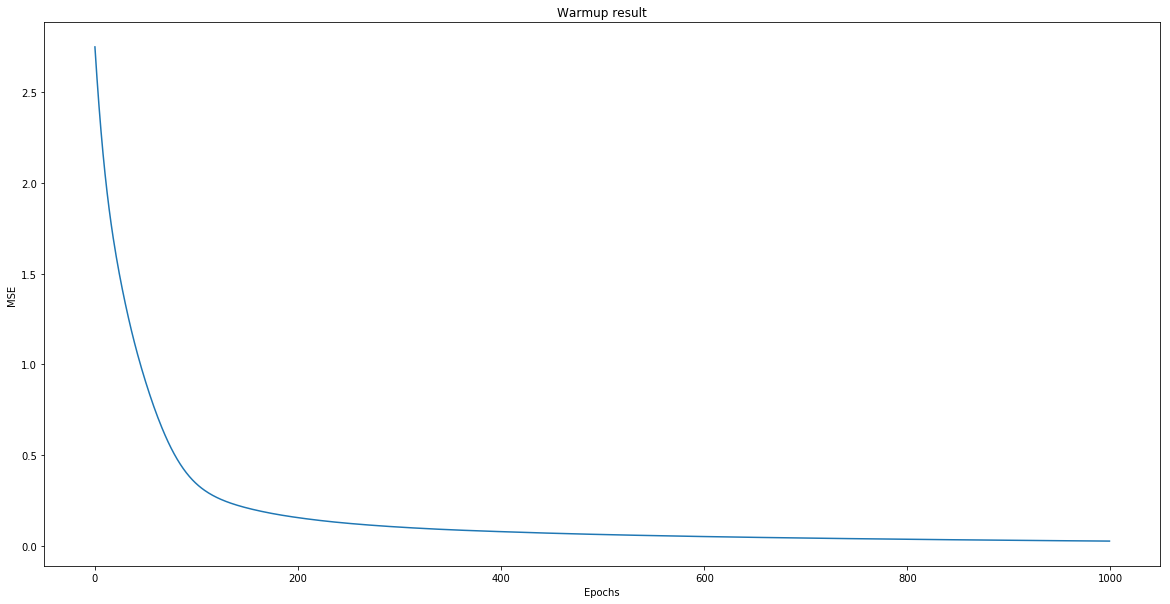

In [9]:
plt.plot(losses)
plt.title('Warmup result')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

## Testing the trained Hopper agent

In [10]:
def policy_wrapper(policy_net):
    def wrapped_policy_net(obs):
        X = Variable(FloatTensor(obs))
        if torch.cuda.is_available():
            X = X.cuda()

        return policy_net(X).cpu().data.numpy()
    return wrapped_policy_net

In [11]:
def TestAgent(policy_fn, env_name='Hopper', render=False, num_rollouts=3, show_after_done=False):
    returns = []
    observations = []
    actions = []
    env = gym.make(env_name+'-v1')
    for i in range(num_rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done or show_after_done:
            action = policy_fn(obs[None,:])
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            observations.append(obs)
            actions.append(action)
            if render:
                env.render()
            #if steps % 100 == 0: print("%i/%i"%(steps, env.spec.timestep_limit))
            if steps >= env.spec.timestep_limit:
                break
        returns.append(totalr)

    if render:
        env.render(close=True)
    
    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))
    agent_data = {'observations': np.array(observations),
                  'actions': np.array(actions)}
    return agent_data, returns

In [12]:
policy_fn = policy_wrapper(policy_net)
agent_data, returns = TestAgent(policy_fn, 'Hopper', True)

[2018-04-08 20:17:18,657] Making new env: Hopper-v1


iter 0
iter 1
iter 2
returns [219.58082427497223, 217.53131725064142, 219.35720942646324]
mean return 218.82311698402563
std of return 0.9179908545285406


#  Behavioral Cloning


- Run  behavioral  cloning  (BC)  and  report  results  on  two  other  tasks  –  one  task  where  a  behavioral cloning agent achieves comparable performance to the expert, and one task where it does not.  Whenproviding  results,  report  the  mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  atable, and state which task was used.  Be sure to set up a fair comparison, in terms of network size,amount of data, and number of training iterations, and provide these details (and any others you feel are appropriate) in the table caption

In [13]:
def GenerateExpertData(env_name, num_rollouts=20, render=True):
    """
    Generates a database of expert observation-action pair of size `num_rollouts` 
    """

    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/%s-v1.pkl'%env_name)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        env = gym.make(env_name+'-v1')
        max_steps = env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if render:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)
        
        if render:
            env.render(close=True)

        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions).squeeze()}
    return expert_data

In [14]:
def VisualizeAgentData(agent_data, rollout_length=1000):
    print(agent_data['observations'].shape)
    plt.plot(agent_data['observations'][:rollout_length])
    plt.title('Observtions of a rollout')
    plt.ylabel('Value')
    plt.xlabel('Time steps')
    plt.show()


    print(agent_data['actions'].shape)
    plt.plot(agent_data['actions'][:rollout_length])
    plt.title('Actions of a rollout')
    plt.ylabel('Value')
    plt.xlabel('Time steps')
    plt.show()

In [15]:
def BCAgent(expert_data, hidden_dims=[64], num_epochs=1000, 
            loss=torch.nn.MSELoss(), pretrained_agent=None):
    # Define agent
    input_dim = expert_data['observations'].shape[-1]
    output_dim = expert_data['actions'].shape[-1]
    if pretrained_agent:
        policy_net = pretrained_agent
    else:        
        policy_net = getMLP(input_dim, output_dim, hidden_dims)
    
    print('Agent\'s Policy function:\n', policy_net)
    
    X = Variable(FloatTensor(expert_data['observations']))
    Y = Variable(FloatTensor(expert_data['actions']))
    if torch.cuda.is_available():
        X = X.cuda()
        Y = Y.cuda()
        policy_net.cuda()
    opt = torch.optim.Adam(policy_net.parameters())
    losses = []
    for epoch in range(num_epochs):
        if epoch % (num_epochs//10) == 0: print('Epoch:', epoch)
        opt.zero_grad()
        actions = policy_net(X)
        L2 = loss(actions, Y)
        L2.backward()
        opt.step()
        losses.append(L2.cpu().data.numpy())

    print('Behaviour cloning finished')
    plt.plot(losses)
    plt.title('BC result')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.show()
    
    return policy_net

## Testing Ant

In [ ]:
ant_expert_data = GenerateExpertData('Ant', num_rollouts=20, render=False)

In [ ]:
ant_policy_network = BCAgent(ant_expert_data, num_epochs=1000)

In [ ]:
ant_policy_fn = policy_wrapper(ant_policy_network)
ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', render=True, num_rollouts=10)

## Testing HalfCheetah

In [ ]:
HC_expert_data = GenerateExpertData('HalfCheetah', num_rollouts=20, render=False)

In [ ]:
HC_policy_network = BCAgent(HC_expert_data, num_epochs=1000)

In [ ]:
HC_policy_fn = policy_wrapper(HC_policy_network)
HC_agent_data, HC_returns = TestAgent(HC_policy_fn, env_name='HalfCheetah', render=False, num_rollouts=10)

## Testing Humanoid

In [ ]:
hum_expert_data = GenerateExpertData('Humanoid', num_rollouts=20, render=False)

In [ ]:
hum_policy_network = BCAgent(hum_expert_data, num_epochs=1000)

In [ ]:
hum_policy_fn = policy_wrapper(hum_policy_network)
hum_agent_data, hum_returns = TestAgent(hum_policy_fn, env_name='Humanoid', 
                                        render=False, num_rollouts=10,
                                        show_after_done=False)

## Table 1

- Expert rollouts: 20
- Hidden: 64 (ReLU)
- Optimizer: Adam (1000 epoch)
- Results from 10 rollouts

(The exact vales may change, since seed was not fixed, still the relations were the same between multiple runs)

Task | Rewards mean | Rewards std
--- | --- | ---
Hopper (expert) | **3779.34** | 3.73
Hopper (ours) | 145.29 | 0.61
Ant (expert) | 4608.11 | 788.98
Ant (ours) | **4724.66** | 133.33
HalfCheetah (expert) | **4156.78** | 90.93
HalfCheetah (ours) | 3012.47 | 219.77
Humanoid (expert) | **10415.85** | 33.61
Humanoid (ours) | 419.70 | 100.55

# Experimenting with HyperParams of BC

- Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such as the number of demonstrations, the number of training epochs, the variance of the expert policy, or something that you come up with yourself.  For one of the tasks used in the previous question, show a graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the hyperparameter and a brief rationale for why you chose it in the caption for the graph.

In [ ]:
mean_rewards = []
test_values = [10, 50, 100, 250, 500, 750, 1000, 1500]
for num_epochs in test_values:
    ant_policy_network = BCAgent(ant_expert_data, num_epochs=num_epochs)
    ant_policy_fn = policy_wrapper(ant_policy_network)
    ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', render=False, num_rollouts=10)
    mean_rewards.append(np.mean(ant_returns))

## Figure 1

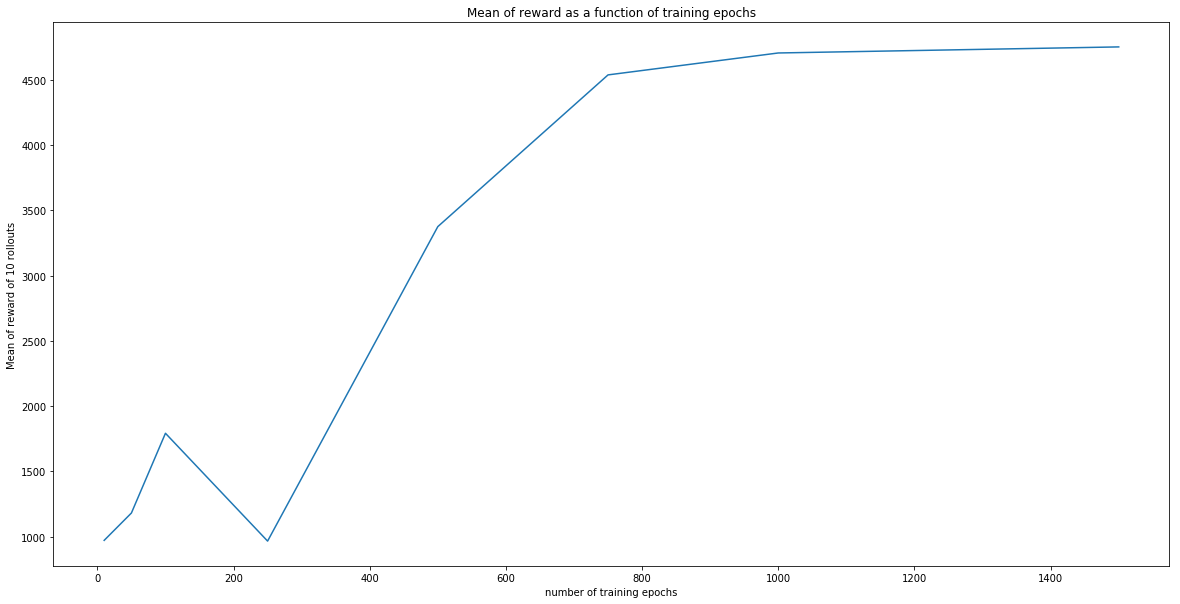

In [69]:
plt.plot(test_values, mean_rewards)
plt.title('Mean of reward as a function of training epochs')
plt.xlabel('number of training epochs')
plt.ylabel('Mean of reward of 10 rollouts')
plt.show()

#### CAPTION:

In the very first implementations none of the trained agents could achieve any decent performance, mainly because of the lack of enough training time. Therefore it seemed interesting to me to depict the curve of the performance wrt. the # of epochs

In [ ]:
hidden_mean_rewards = []
test_values = range(2, 32)
for hidden_dim in test_values:
    ant_policy_network = BCAgent(ant_expert_data, hidden_dims=[hidden_dim], num_epochs=1000)
    ant_policy_fn = policy_wrapper(ant_policy_network)
    ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', render=False, 
                                            num_rollouts=3)
    hidden_mean_rewards.append(np.mean(ant_returns))

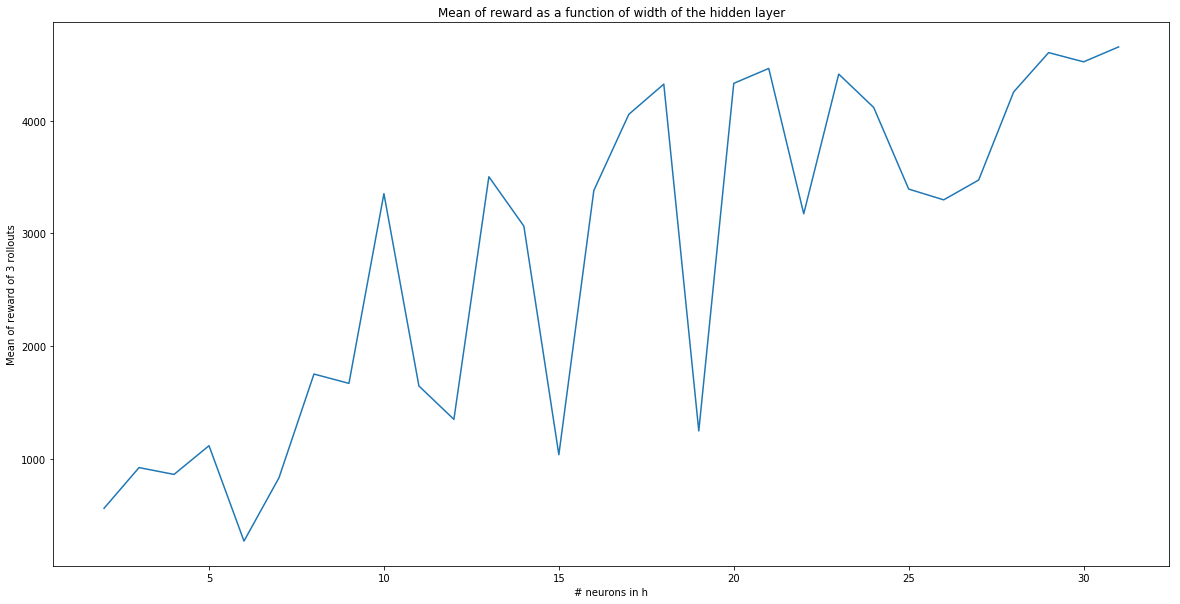

In [84]:
plt.plot(test_values, hidden_mean_rewards)
plt.title('Mean of reward as a function of width of the hidden layer')
plt.xlabel('# neurons in h')
plt.ylabel('Mean of reward of 3 rollouts')
plt.show()

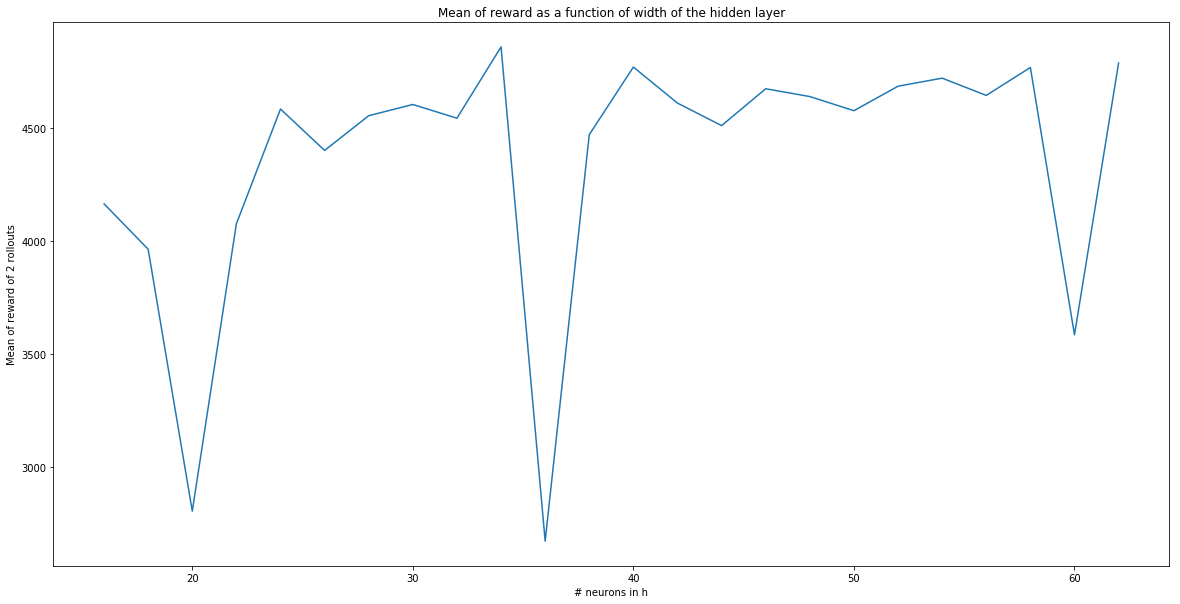

In [82]:
plt.plot(test_values, hidden_mean_rewards)
plt.title('Mean of reward as a function of width of the hidden layer')
plt.xlabel('# neurons in h')
plt.ylabel('Mean of reward of 2 rollouts')
plt.show()

It may be an expensive but quite describing metric if we take the performance as the function of the capacity of the underlying neural network.

As it was pointed out in [Deep Reinforcement Learning that Matters](https://arxiv.org/pdf/1709.06560.pdf): often there is no consistency in the type of network architectures and activation functions that are used in related literature. As shown in the paper and from our experimental results in later sections, we find, however, that these hyperparameters can have a significant effect in the performance of algorithms across benchmark environments typically used.

Maybe I should also experiment with the depth of the policy network, but that would be an overkill for now.

## DAgger

- Implement Domain Aggregation (DAgger). See the code provided in `run_expert.py` to see how to query the expert policy and perform roll-outs in the environment.

In [31]:
def SolveWithExpert(agent_data, env_name='Humanoid'):
    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/%s-v1.pkl'%env_name)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        # WWJD
        expert_action = policy_fn(agent_data['observations'])
    
    
    expert_data = {'observations': agent_data['observations'],
                   'actions': expert_action}
    return expert_data
    

In [32]:
# Storing the original experiments
orig_expert_data = hum_expert_data.copy()
orig_agent_data = hum_agent_data.copy()
env_name = 'Humanoid'

In [ ]:
# Step 0
expert_data = orig_expert_data.copy()
agent_data = orig_agent_data.copy()
policy_network = BCAgent(expert_data)

num_dagger = 20
num_rollouts = 3

agent_rewards_mean = []
agent_rewards_std = []
expert_mean_rewards = np.ones(num_dagger) * 10415.85

for i in range(num_dagger):
    print('iter:', i)
    # Step i
    # EXTEND the training database with:
    # observations of the trained agent
    # actions of an expert agent
    new_expert_data = SolveWithExpert(agent_data, env_name=env_name)
    print(new_expert_data['observations'].shape, new_expert_data['actions'].shape)
    expert_data['observations'] = np.concatenate(
        (expert_data['observations'], new_expert_data['observations']))
    print(expert_data['observations'].shape)
    expert_data['actions'] = np.concatenate(
        (expert_data['actions'], new_expert_data['actions']))
    print(expert_data['actions'].shape)
    # Train an agent on the extended database
    policy_network = BCAgent(expert_data, pretrained_agent=policy_network)
    policy_fn = policy_wrapper(policy_network)
    agent_data, agent_returns = TestAgent(
        policy_fn, env_name=env_name, 
        render=True, num_rollouts=num_rollouts)
    
    agent_rewards_mean.append(np.mean(agent_returns))
    agent_rewards_std.append(np.std(agent_returns))

-  Run DAgger and report results on one task in which DAgger can learn a better policy than behavioral cloning.  Report your results in the form of a learning curve, plotting the number of DAgger iterations vs.  the policy’s mean return, with error bars to show the standard deviation.  Include the performance of the expert policy and the behavioral cloning agent on the same plot.  In the caption, state which task you used, and any details regarding network architecture, amount of data, etc.  (as in the previous section).

### Figure 2

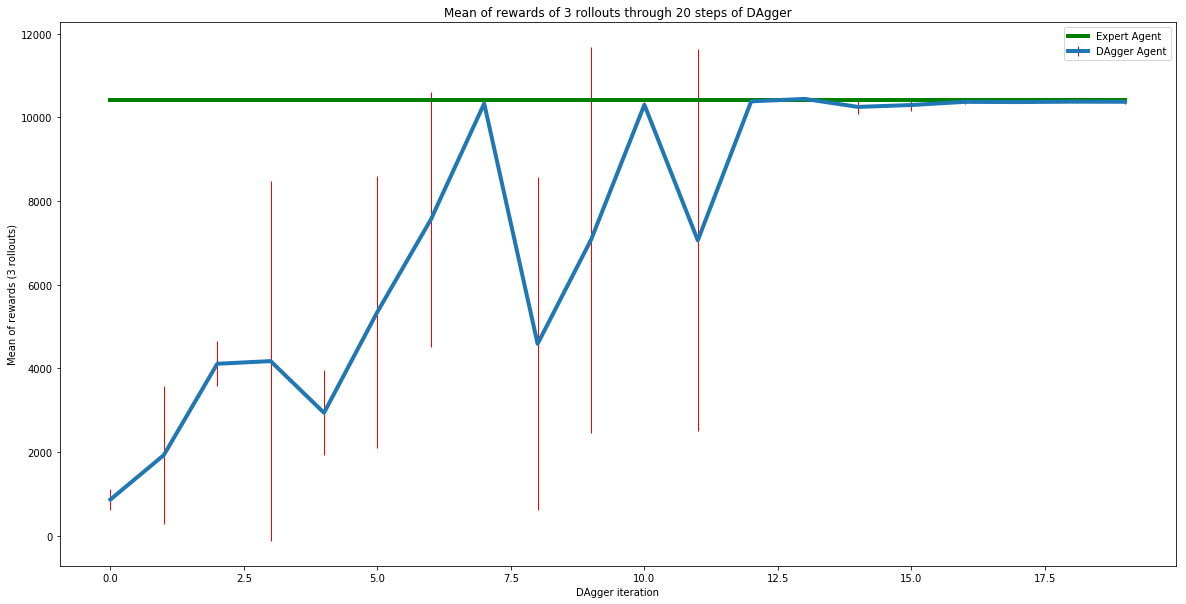

In [68]:
plt.errorbar(range(num_dagger), agent_rewards_mean, agent_rewards_std, 
             ecolor='r', linewidth=4, elinewidth=1, capthick=2, 
             label='DAgger Agent')
plt.plot(expert_mean_rewards, linewidth=4, color='green',
         label='Expert Agent')

plt.title('Mean of rewards of 3 rollouts through 20 steps of DAgger')
plt.xlabel('DAgger iteration')
plt.ylabel('Mean of rewards (3 rollouts)')
plt.legend()
plt.show()

#### Caption:
I've used the Humanoid-v1 task, which was underperforming in vanilla BC.

Details:
- Network: 64 ReLU
- Optimizer: Adam (1000 epochs)
- Original expert training samples: 20k
- \# DAgger extension: 10
- \# rollouts with the fine-tuned agent: 3